# CAE

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
# from skimage.io import imread
# from skimage.transform import resize, rotate
import matplotlib.pyplot as plt

tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load index csv

In [2]:
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())

dataset_size = dataset_index.shape[0]

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']
print(dataset_index.shape)
print(dataset_index.head())

(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg


## Load and rotate images

Instructions for updating:
Colocations handled automatically by placer.


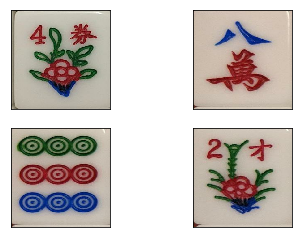

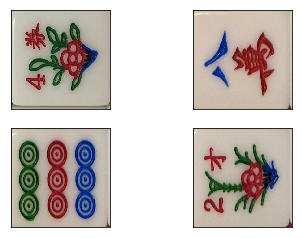

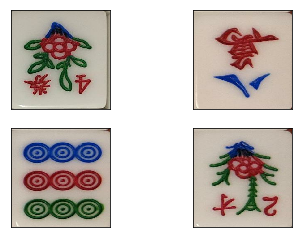

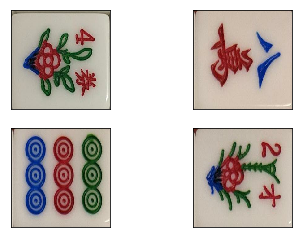

In [3]:
def show_image_sample(ds):
    for n,image in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds)

# image_data = np.empty((1,320,320,3))
# for image_path in dataset_index['image-path']:
#     image = imread(image_path)
#     image = resize(image, (320,320))
#     np.append(image_data, image[np.newaxis:])

def rotate_image(image):
    image = tf.image.rot90(image)
    return image

image_ds_90 = image_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_90)

image_ds_180 = image_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_180)

image_ds_270 = image_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_270)

dataset_size *= 4

## Create image-label pairs

In [4]:
# label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(dataset_index['label'], tf.int64))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

# for n,(image,label) in enumerate(image_label_ds.take(4)):
#     plt.subplot(2,2,n+1)
#     plt.imshow(image)
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     plt.xlabel(label)

## Concat, Add noise to input and Split into subsets

(320, 320, 3)
add noise done
conbine done
shuffle done
split done
(TensorShape([Dimension(320), Dimension(320), Dimension(3)]), TensorShape([Dimension(320), Dimension(320), Dimension(3)]))


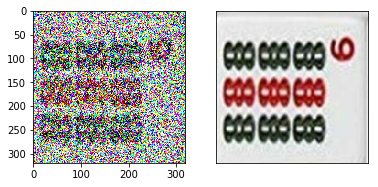

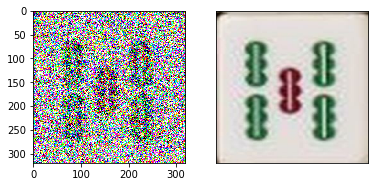

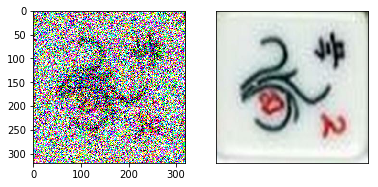

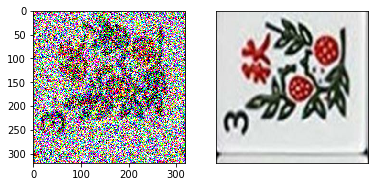

(TensorShape([Dimension(320), Dimension(320), Dimension(3)]), TensorShape([Dimension(320), Dimension(320), Dimension(3)]))


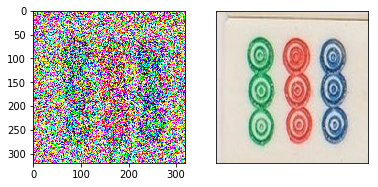

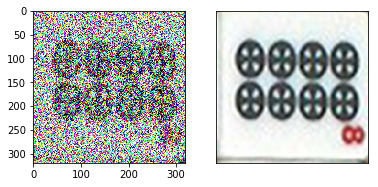

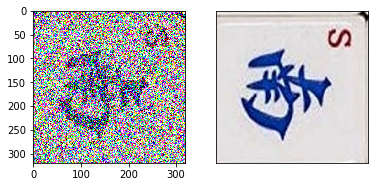

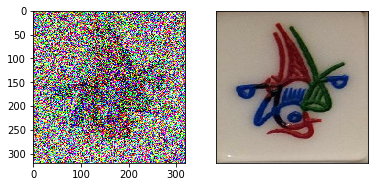

(TensorShape([Dimension(320), Dimension(320), Dimension(3)]), TensorShape([Dimension(320), Dimension(320), Dimension(3)]))


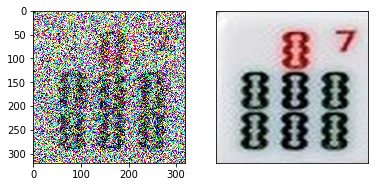

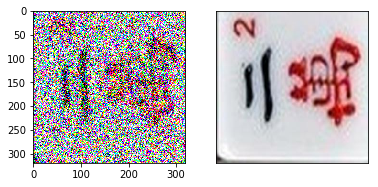

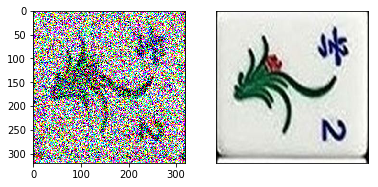

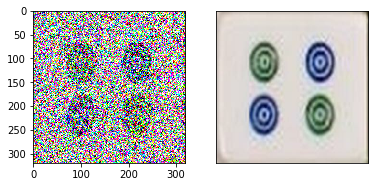

In [4]:
def show_noisy_image_sample(ds):
    for n,(noisy, orig) in enumerate(ds.take(4)):
        plt.subplot(1,2,1)
        plt.imshow(noisy)
        plt.subplot(1,2,2)
        plt.imshow(orig)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.show()

def add_noise(image):
    print(image.shape)
    noise = tf.random.normal(shape=image.shape, mean=0.0, stddev=1.0)
    image += noise
    return tf.clip_by_value(image, 0, 1)
    
all_image_ds = image_ds.concatenate(image_ds_90).concatenate(image_ds_180).concatenate(image_ds_270)
all_image_ds_noisy = all_image_ds.map(add_noise, num_parallel_calls=AUTOTUNE)
print('add noise done')
all_image_ds = tf.data.Dataset.zip((all_image_ds_noisy, all_image_ds))
print('conbine done')
all_image_ds = all_image_ds.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False) # affects randomness, best > size
print('shuffle done')

# train-test split
train_ds = all_image_ds.take(int(dataset_size * 0.7)) # 70% train
test_ds = all_image_ds.skip(int(dataset_size * 0.7)) # 30% test
# train-val split
val_ds = train_ds.skip(int(dataset_size * 0.7 * 0.8)) # 20% val
train_ds = train_ds.take(int(dataset_size * 0.7 * 0.8)) # 80% train
print('split done')

print(train_ds.output_shapes)
show_noisy_image_sample(train_ds)

print(val_ds.output_shapes)
show_noisy_image_sample(val_ds)

print(test_ds.output_shapes)
show_noisy_image_sample(test_ds)

## Train CAE Model

In [5]:
# BN - (Conv - ReLU - Dropout) x 4?
encoder = keras.Sequential([
    keras.layers.Conv2D(filters=2, kernel_size=4, strides=2, activation='relu', input_shape=(320,320,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2D(filters=4, kernel_size=3, strides=2, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu')
])
decoder = keras.Sequential([
    keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=1, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=1, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=1, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=2, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Conv2DTranspose(filters=2, kernel_size=4, strides=2, activation='relu')
])

cae = keras.Sequential([encoder, decoder])
cae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

train_ds = train_ds.batch(32, drop_remainder=True).repeat()
val_ds = val_ds.batch(32, drop_remainder=True).repeat()

cae.fit(x=train_ds, epochs=10, steps_per_epoch=30, validation_data=val_ds, validation_steps=3)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
Instructions for updating:
Use tf.cast instead.


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_7/Conv2D}}]] [Op:StatefulPartitionedCall]